<a href="https://colab.research.google.com/github/purrvaja/Time-Series-Forecasting/blob/main/pyspark_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Dependencies and Dataset

In [1]:
!pip install Prophet
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=23b85ab4751ce796ca7b74bfe5b2564c52e823e9804385bf66ecb99fbaba5a6c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# import data

sample = pd.read_csv('/content/gdrive/My Drive/Data Science/Pyspark/sample_submission.csv')
train = pd.read_csv('/content/gdrive/My Drive/Data Science/Pyspark/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/Data Science/Pyspark/test.csv')

df = pd.concat([train, test])
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


#### Pre Processing

In [4]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    958000 non-null  object 
 1   store   958000 non-null  int64  
 2   item    958000 non-null  int64  
 3   sales   913000 non-null  float64
 4   id      45000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 43.9+ MB


In [ ]:
df.shape

(958000, 5)

In [ ]:
df.describe()

,store,item,sales,id
count,958000.000000,958000.000000,913000.000000,45000.000000
mean,5.500000,25.500000,52.250287,22499.500000
std,2.872283,14.430877,28.801144,12990.525394
min,1.000000,1.000000,0.000000,0.000000
25%,3.000000,13.000000,30.000000,11249.750000
50%,5.500000,25.500000,47.000000,22499.500000
75%,8.000000,38.000000,70.000000,33749.250000
max,10.000000,50.000000,231.000000,44999.000000


In [ ]:
# Number of unique products and stores

df[['store', 'item']].nunique()

# 50 items and 10 stores -- this means 500 unique groups

store    10
item     50
dtype: int64

In [ ]:
df.isnull().sum()

date          0
store         0
item          0
sales     45000
id       913000
dtype: int64

In [6]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract year from date
df['year'] = df['date'].dt.year


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      0 non-null       float64       
 5   year    913000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 48.8 MB


In [7]:
# Count missing values for each year
df['sales'].isnull().groupby([df['year']]).sum()

year
2013        0
2014        0
2015        0
2016        0
2017        0
2018    45000
Name: sales, dtype: int64

In [8]:
# all missing values from sales are in 2018
# checking for non-missing values

df[df['year'] == 2018]['sales'].notnull().sum()

0

In [9]:
# since there are no values available for 2018, dropping this year
df = df[df['year'] != 2018]

#### EDA

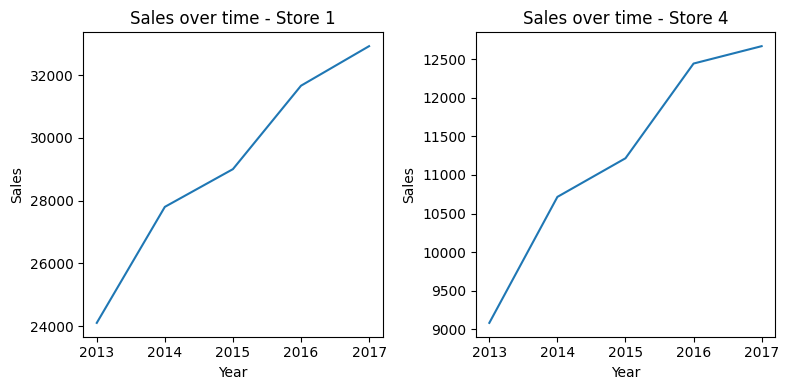

In [54]:
# visualising the sales over time for two different stores and items combinations

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(df[(df['store']==1) & (df['item'] == 15)].groupby('year').sum().reset_index()['year'],
         df[(df['store']==1) & (df['item'] == 15)].groupby('year').sum().reset_index()['sales'])

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales over time - Store 1')


plt.subplot(1, 2, 2)
plt.plot(df[(df['store']==4) & (df['item'] == 23)].groupby('year').sum().reset_index()['year'],
         df[(df['store']==4) & (df['item'] == 23)].groupby('year').sum().reset_index()['sales'])

plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales over time - Store 4')


# Adjust spacing and layout
plt.tight_layout()

# Show the plot
plt.show()

## PySpark x Prophet

#### Initalizing PySpark

In [ ]:
https://www.analyticsvidhya.com/blog/2022/01/apache-spark-and-facebook-prophet/

In [55]:
# df to use for forecasting

df = df[['date', 'store', 'item', 'sales']]

# renaming the columns according to prophet requirements
df.rename({'date': 'ds',
           'sales': 'y'}, axis=1, inplace=True)

In [56]:
spark = SparkSession.builder\
        .appName("Prophet x Pyspark")\
        .getOrCreate()

In [57]:
df = spark.createDataFrame(df)

df.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- store: long (nullable = true)
 |-- item: long (nullable = true)
 |-- y: double (nullable = true)



#### Parallelization using PySpark

In [58]:
# partition the data
df.createOrReplaceTempView("item_sales")

sql = "select * from item_sales"
sales_part = (spark.sql(sql)\
   .repartition(spark.sparkContext.defaultParallelism,
   ['store', 'item'])).cache()
sales_part.explain()


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- InMemoryTableScan [ds#0, store#1L, item#2L, y#3]
      +- InMemoryRelation [ds#0, store#1L, item#2L, y#3], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- AdaptiveSparkPlan isFinalPlan=false
               +- Exchange hashpartitioning(store#1L, item#2L, 2), REPARTITION_BY_NUM, [plan_id=9]
                  +- Scan ExistingRDD[ds#0,store#1L,item#2L,y#3]




In [59]:

# Define a schema for the resulting dataframe
schema = StructType([
                     StructField('store', IntegerType()),
                     StructField('item', IntegerType()),
                     StructField('ds', TimestampType()),
                     StructField('y', FloatType()),
                     StructField('yhat', DoubleType()),
                     StructField('yhat_upper', DoubleType()),
                     StructField('yhat_lower', DoubleType()),
                     ])

In [60]:
# utlize pandasudf and pyspark to train multiple models in parallel


# define the Pandas UDF
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def apply_model(store_pd):

  # instantiate the model and set parameters
  model = Prophet(
      interval_width=0.95,
      growth='linear',
      daily_seasonality=False,
      weekly_seasonality=True,
      yearly_seasonality=True,
      seasonality_mode='multiplicative'
  )

  # fit the model to historical data
  model.fit(store_pd)

  # Create a data frame that lists 90 dates starting from Jan 1 2018
  future = model.make_future_dataframe(
      periods=90,
      freq='d',
      include_history=True)

  # Out of sample prediction
  future = model.predict(future)

  # Create a data frame that contains store, item, y, and yhat
  f_pd = future[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
  st_pd = store_pd[['ds', 'store', 'item', 'y']]
  result_pd = f_pd.join(st_pd.set_index('ds'), on='ds', how='left')

  # fill store and item
  result_pd['store'] = store_pd['store'].iloc[0]
  result_pd['item'] = store_pd['item'].iloc[0]
  #result_pd['store'] = store_pd['store'].fillna(method='ffill')
  #result_pd['item'] = store_pd['item'].fillna(method='ffill')
  return result_pd[['store', 'item', 'ds', 'y', 'yhat',
                    'yhat_upper', 'yhat_lower']]



In [61]:
# Apply the function to all store-items
results = sales_part.groupby(['store', 'item']).apply(apply_model)

# Calculate the time to run and print results
import timeit
start = timeit.default_timer()
results.show()
stop = timeit.default_timer()

+-----+----+-------------------+----+------------------+------------------+-------------------+
|store|item|                 ds|   y|              yhat|        yhat_upper|         yhat_lower|
+-----+----+-------------------+----+------------------+------------------+-------------------+
|    1|   1|2013-01-01 00:00:00|13.0|10.049159300101701| 18.53477495199446|  1.624737398043951|
|    1|   1|2013-01-02 00:00:00|11.0|10.527840390511644|19.006124951062638| 2.0885774478750565|
|    1|   1|2013-01-03 00:00:00|14.0|11.054166561400262|18.697771478040067|   2.50380187100842|
|    1|   1|2013-01-04 00:00:00|13.0| 12.24711024575307| 20.40369690704511|  3.342680133757046|
|    1|   1|2013-01-05 00:00:00|10.0|13.786035240028944| 22.35668743074548|  4.568525056690701|
|    1|   1|2013-01-06 00:00:00|12.0|14.386006135339562| 23.40073041293507|  5.978038081176348|
|    1|   1|2013-01-07 00:00:00|10.0| 7.874016010818567| 15.87824370627552|-1.1292648213810357|
|    1|   1|2013-01-08 00:00:00| 9.0| 9.

In [62]:
# Print the time it took to forecast 500 models
print('Time: ', stop - start)


Time:  21.919004285000028


In [63]:
results.coalesce(1)
results.createOrReplaceTempView('forecasted')
spark.sql("SELECT * FROM forecasted WHERE ITEM==1 AND STORE==1").show()

+-----+----+-------------------+----+------------------+------------------+-------------------+
|store|item|                 ds|   y|              yhat|        yhat_upper|         yhat_lower|
+-----+----+-------------------+----+------------------+------------------+-------------------+
|    1|   1|2013-01-01 00:00:00|13.0|10.049159300101701| 18.53477495199446|  1.624737398043951|
|    1|   1|2013-01-02 00:00:00|11.0|10.527840390511644|19.006124951062638| 2.0885774478750565|
|    1|   1|2013-01-03 00:00:00|14.0|11.054166561400262|18.697771478040067|   2.50380187100842|
|    1|   1|2013-01-04 00:00:00|13.0| 12.24711024575307| 20.40369690704511|  3.342680133757046|
|    1|   1|2013-01-05 00:00:00|10.0|13.786035240028944| 22.35668743074548|  4.568525056690701|
|    1|   1|2013-01-06 00:00:00|12.0|14.386006135339562| 23.40073041293507|  5.978038081176348|
|    1|   1|2013-01-07 00:00:00|10.0| 7.874016010818567| 15.87824370627552|-1.1292648213810357|
|    1|   1|2013-01-08 00:00:00| 9.0| 9.

In [64]:
# Converting the pyspark dataframe to pandas dataframe for visualization

final_df = results.toPandas()

In [65]:
final_df.head()

,store,item,ds,y,yhat,yhat_upper,yhat_lower
0,1,1,2013-01-01,13.0,10.049159,18.534775,1.624737
1,1,1,2013-01-02,11.0,10.527840,19.006125,2.088577
2,1,1,2013-01-03,14.0,11.054167,18.697771,2.503802
3,1,1,2013-01-04,13.0,12.247110,20.403697,3.342680
4,1,1,2013-01-05,10.0,13.786035,22.356687,4.568525


In [68]:
final_df.columns

Index(['store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'], dtype='object')

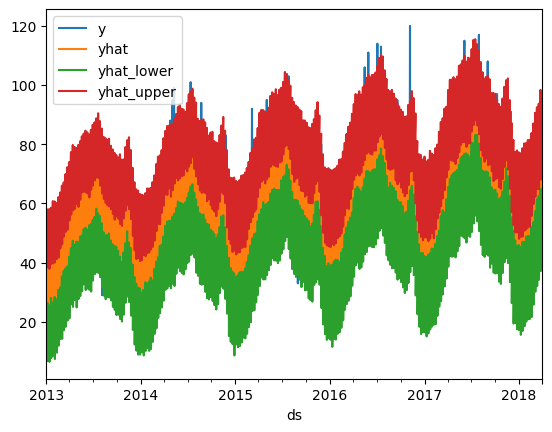

In [73]:
#final_df = final_df.set_index('ds')
#final_df.query('store == 5')[['y', 'yhat']].plot()
final_df[(final_df['store'] == 5) & (final_df['item']==8)][['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot()
plt.show()

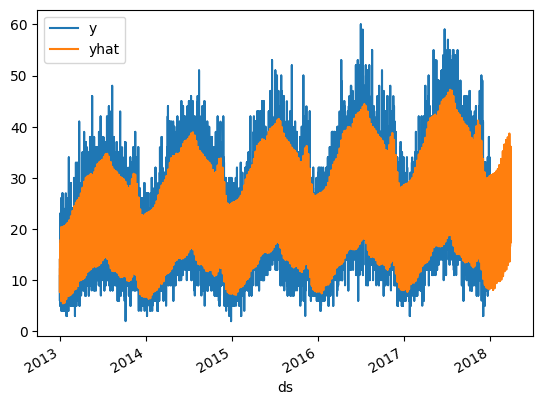

In [74]:
final_df.query('item == 41')[['y', 'yhat']].plot()
plt.show()